In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("demand_forecasting_dataset.csv")
df

,date,product_id,sales_units,holiday_season,promotion_applied,competitor_price_index,economic_index,weather_impact,price,discount_percentage,sales_revenue,region_Europe,region_North America,store_type_Retail,store_type_Wholesale,category_Cabinets,category_Chairs,category_Sofas,category_Tables,future_demand
0,2023-01-01,151,99,0,0,0.983893,1.314333,0,126.932922,0.000000,12566.359326,False,False,True,False,False,True,False,False,95.0
1,2023-01-02,192,95,1,0,0.977615,1.439582,0,151.355405,0.000000,14378.763512,False,True,False,False,True,False,False,False,101.0
2,2023-01-03,114,101,0,0,0.983913,1.094795,0,191.701693,0.000000,19361.870952,False,False,False,True,True,False,False,False,33.0
3,2023-01-04,171,33,0,0,1.191956,0.907672,0,173.106487,0.000000,5712.514059,False,False,False,True,False,True,False,False,82.0
4,2023-01-05,160,82,0,1,0.855711,1.479690,0,138.587491,10.995213,10114.659145,True,False,False,False,False,False,True,False,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2036-09-03,135,145,0,0,1.056679,1.070775,0,71.619056,0.000000,10384.763053,False,True,False,True,False,False,True,False,30.0
4995,2036-09-04,148,30,1,0,0.943824,0.588744,0,156.059583,0.000000,4681.787499,False,True,False,False,False,True,False,False,65.0
4996,2036-09-05,157,65,0,0,1.126866,0.744654,1,122.872619,0.000000,7986.720266,False,True,False,True,True,False,False,False,55.0
4997,2036-09-06,138,55,0,0,0.835702,1.409860,0,59.899614,0.000000,3294.478765,False,True,False,True,False,False,True,False,52.0


# Tratamento e Limepeza dos Dados

In [5]:
# --- Conversão de colunas de data para datetime ---
df['date'] = pd.to_datetime(df['date'])

# --- Verificação e tratamento de valores ausentes ---
missing = df.isnull().sum()
print("Valores ausentes por coluna:\n", missing)

# --- Conversão de variáveis booleanas para inteiros ---
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

Valores ausentes por coluna:
 date                      0
product_id                0
sales_units               0
holiday_season            0
promotion_applied         0
competitor_price_index    0
economic_index            0
weather_impact            0
price                     0
discount_percentage       0
sales_revenue             0
region_Europe             0
region_North America      0
store_type_Retail         0
store_type_Wholesale      0
category_Cabinets         0
category_Chairs           0
category_Sofas            0
category_Tables           0
future_demand             0
dtype: int64


# Gráficos

C:\Users\Adriano\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


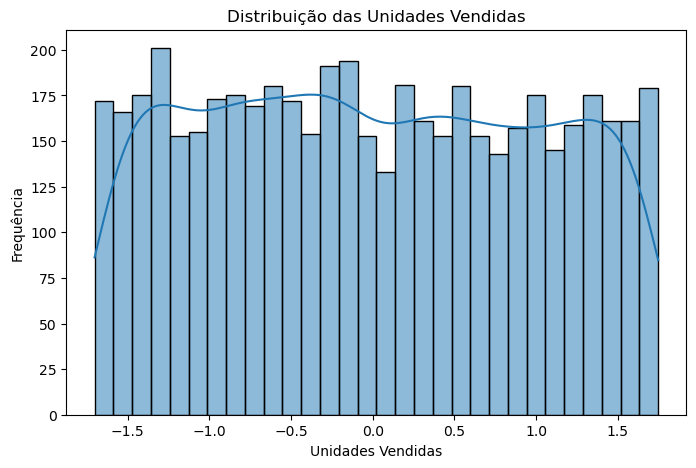

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['sales_units'], bins=30, kde=True)
plt.title('Distribuição das Unidades Vendidas')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Frequência')
plt.show()

Histograma que mostra como as vendas estão distribuídas no dataset, evidenciando, por exemplo, se a maioria das vendas são baixas, médias ou altas, e se há outliers.

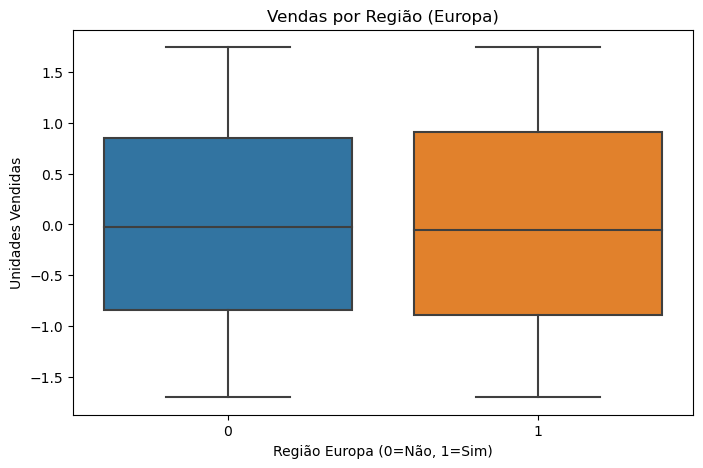

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(x='region_Europe', y='sales_units', data=df)
plt.title('Vendas por Região (Europa)')
plt.xlabel('Região Europa (0=Não, 1=Sim)')
plt.ylabel('Unidades Vendidas')
plt.show()


Este boxplot compara a distribuição das unidades vendidas em vendas feitas na Europa versus outras regiões. Permite observar diferenças e variações regionais no desempenho das vendas.

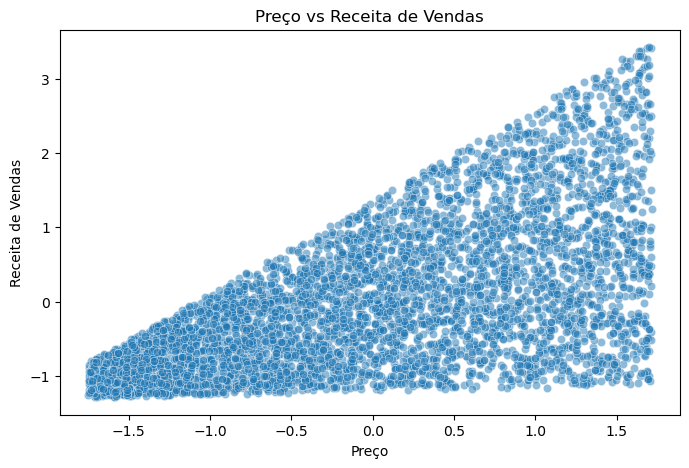

In [10]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='price', y='sales_revenue', data=df, alpha=0.5)
plt.title('Preço vs Receita de Vendas')
plt.xlabel('Preço')
plt.ylabel('Receita de Vendas')
plt.show()


O gráfico de dispersão mostra a relação entre o preço do produto e a receita gerada por suas vendas. Geralmente, pode-se observar se preços maiores levam a maior receita ou se existe alguma outra tendência importante no comportamento das vendas.

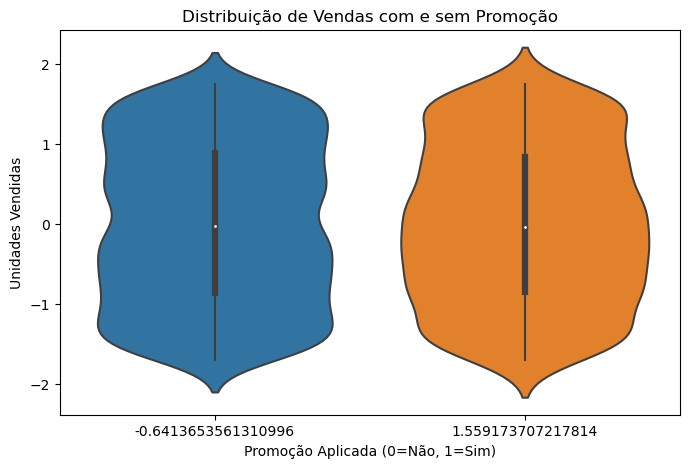

In [12]:
plt.figure(figsize=(8,5))
sns.violinplot(x='promotion_applied', y='sales_units', data=df)
plt.title('Distribuição de Vendas com e sem Promoção')
plt.xlabel('Promoção Aplicada (0=Não, 1=Sim)')
plt.ylabel('Unidades Vendidas')
plt.show()


O gráfico (violin plot) mostra como a distribuição das unidades vendidas varia quando há promoção aplicada versus quando não há. Ajuda a avaliar o impacto das promoções sobre o volume de vendas.

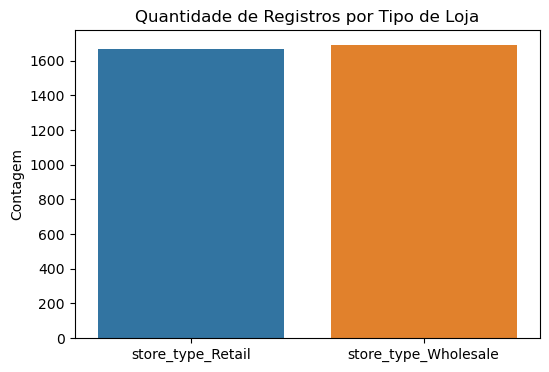

In [13]:
store_counts = df[['store_type_Retail', 'store_type_Wholesale']].sum()

plt.figure(figsize=(6,4))
sns.barplot(x=store_counts.index, y=store_counts.values)
plt.title('Quantidade de Registros por Tipo de Loja')
plt.ylabel('Contagem')
plt.show()


Este gráfico de barras mostra a quantidade de registros no dataset para cada tipo de loja (varejo e atacado). Ele ajuda a entender a distribuição dos dados em relação ao canal de venda, o que pode influenciar na análise de comportamento dos clientes.

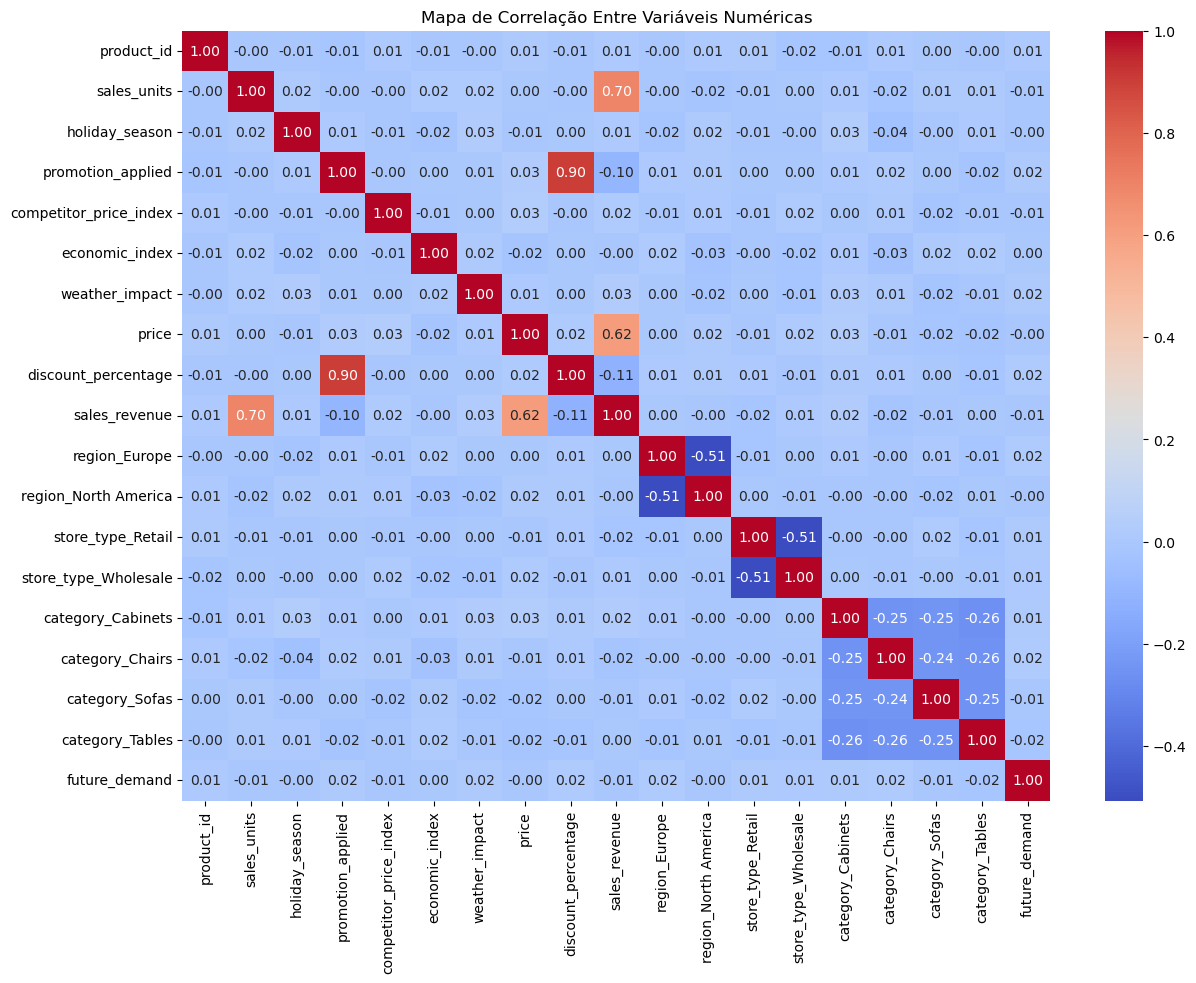

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Mapa de Correlação Entre Variáveis Numéricas")
plt.show()


Este gráfico mostra a correlação entre as variáveis numéricas do dataset, indicando a força e direção da relação entre elas. Valores próximos de +1 indicam forte correlação positiva, próximos de -1 indicam correlação negativa, e valores perto de 0 indicam pouca ou nenhuma correlação. É útil para identificar quais variáveis influenciam umas às outras.

# Análise Exploratória

In [18]:
# --- Estatísticas básicas: médias e desvios padrão ---
print("Médias:")
print(df[['sales_units', 'price', 'discount_percentage', 'future_demand']].mean())
print("\nDesvios Padrão:")
print(df[['sales_units', 'price', 'discount_percentage', 'future_demand']].std())


Médias:
sales_units            3.766630e-17
price                  8.386081e-17
discount_percentage   -3.127013e-17
future_demand          1.032931e+02
dtype: float64

Desvios Padrão:
sales_units             1.000100
price                   1.000100
discount_percentage     1.000100
future_demand          54.806308
dtype: float64


C:\Users\Adriano\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adriano\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adriano\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adriano\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

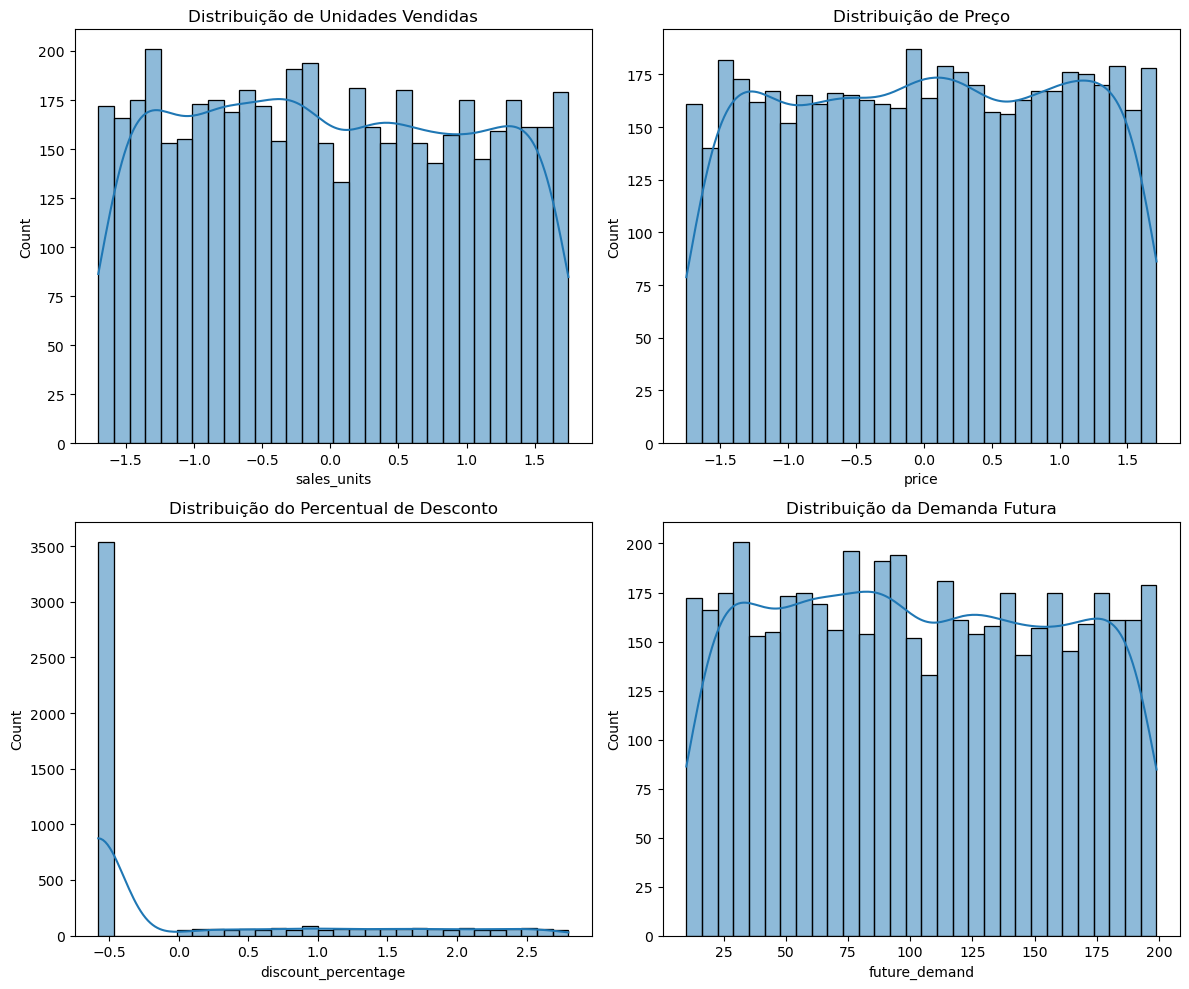

In [19]:
# --- Histogramas para variáveis selecionadas ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['sales_units'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribuição de Unidades Vendidas')

sns.histplot(df['price'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribuição de Preço')

sns.histplot(df['discount_percentage'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('Distribuição do Percentual de Desconto')

sns.histplot(df['future_demand'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('Distribuição da Demanda Futura')

plt.tight_layout()
plt.show()

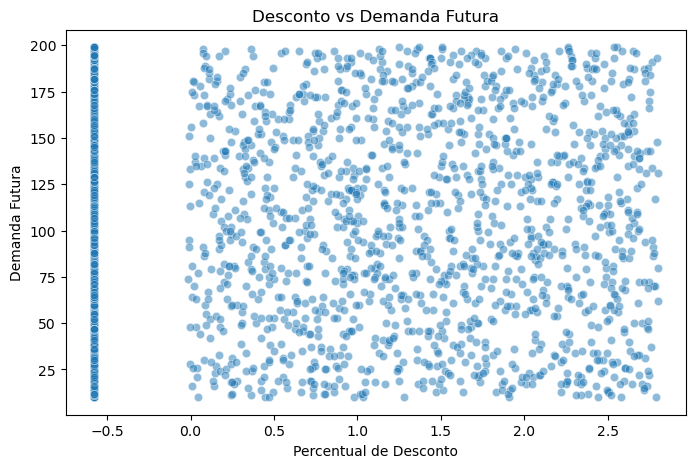

In [25]:
# --- Gráfico de dispersão: desconto x demanda futura ---
plt.figure(figsize=(8,5))
sns.scatterplot(x='discount_percentage', y='future_demand', data=df, alpha=0.5)
plt.title('Desconto vs Demanda Futura')
plt.xlabel('Percentual de Desconto')
plt.ylabel('Demanda Futura')
plt.show()

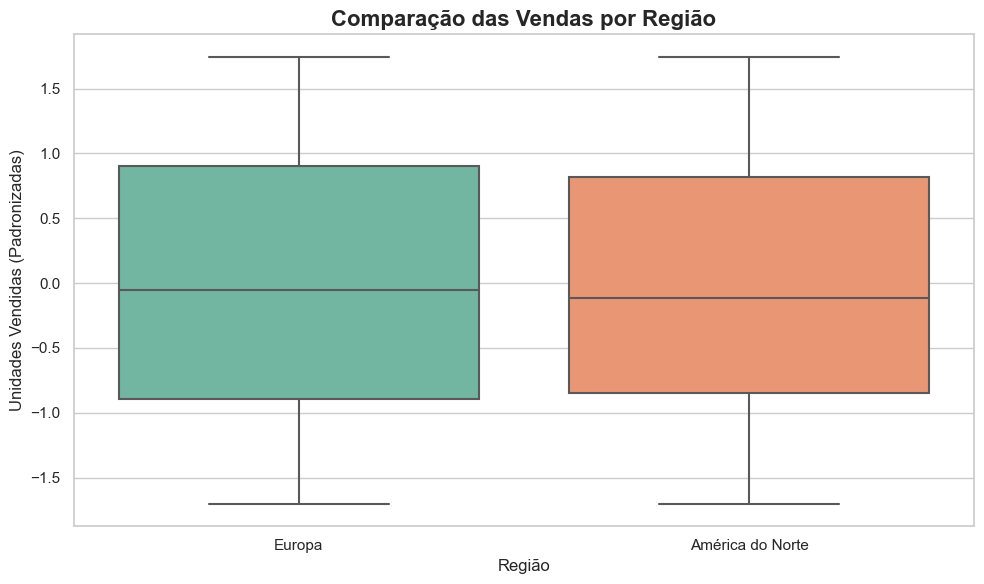

In [35]:
df_europa = df[df['region_Europe'] == 1]
df_america = df[df['region_North America'] == 1]

df_regioes = pd.DataFrame({
    'sales_units': pd.concat([df_europa['sales_units'], df_america['sales_units']], ignore_index=True),
    'region': ['Europa'] * len(df_europa) + ['América do Norte'] * len(df_america)
})

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='sales_units', data=df_regioes, palette='Set2')
plt.title('Comparação das Vendas por Região', fontsize=16, fontweight='bold')
plt.xlabel('Região', fontsize=12)
plt.ylabel('Unidades Vendidas (Padronizadas)', fontsize=12)
plt.tight_layout()
plt.show()

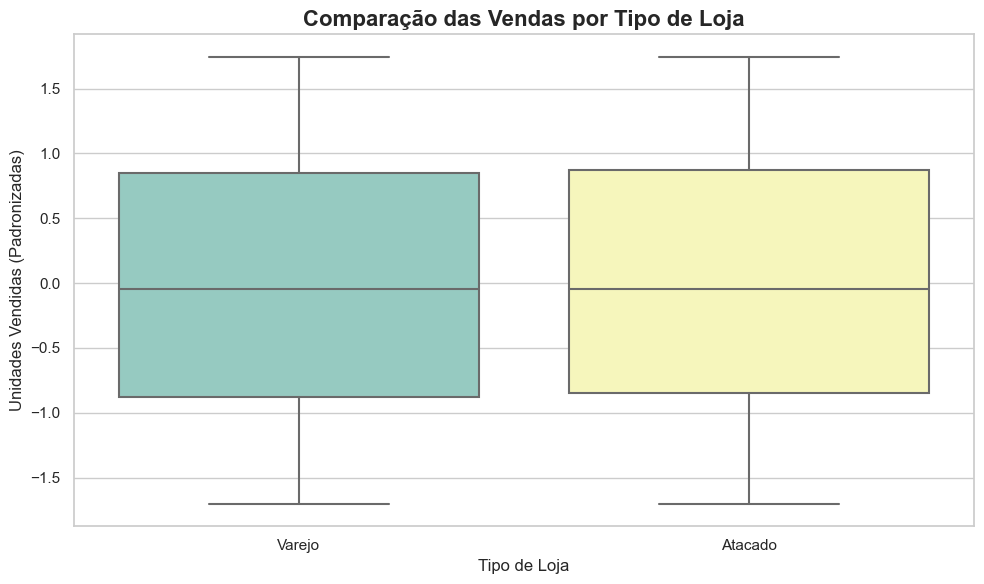

In [36]:
df_retail = df[df['store_type_Retail'] == 1]
df_wholesale = df[df['store_type_Wholesale'] == 1]

df_store_type = pd.DataFrame({
    'sales_units': pd.concat([df_retail['sales_units'], df_wholesale['sales_units']], ignore_index=True),
    'store_type': ['Varejo'] * len(df_retail) + ['Atacado'] * len(df_wholesale)
})

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='store_type', y='sales_units', data=df_store_type, palette='Set3')
plt.title('Comparação das Vendas por Tipo de Loja', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Loja', fontsize=12)
plt.ylabel('Unidades Vendidas (Padronizadas)', fontsize=12)
plt.tight_layout()
plt.show()

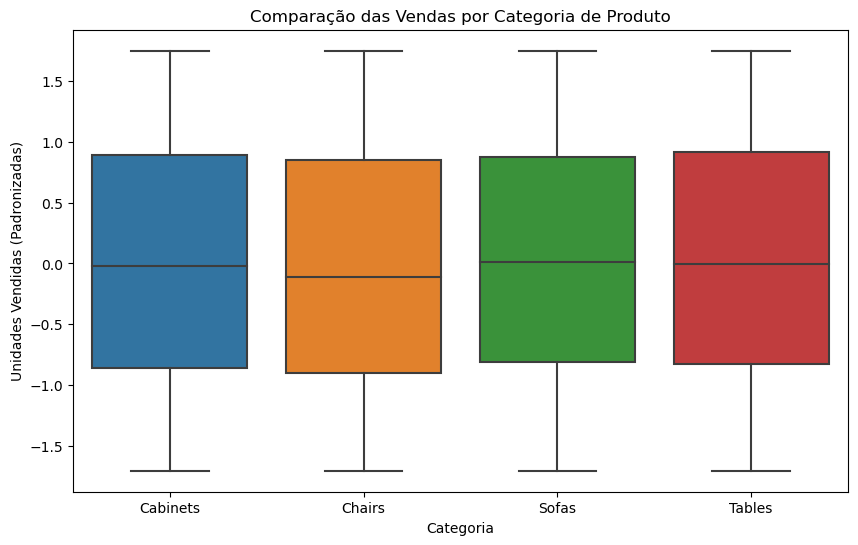

In [34]:
categories = ['category_Cabinets', 'category_Chairs', 'category_Sofas', 'category_Tables']

dados = []

for cat in categories:
    vendas_cat = df[df[cat] == 1]['sales_units']
    temp_df = pd.DataFrame({
        'sales_units': vendas_cat,
        'category': cat.split('_')[1]
    })
    dados.append(temp_df)

df_categories = pd.concat(dados)

plt.figure(figsize=(10,6))
sns.boxplot(x='category', y='sales_units', data=df_categories)
plt.title('Comparação das Vendas por Categoria de Produto')
plt.xlabel('Categoria')
plt.ylabel('Unidades Vendidas (Padronizadas)')
plt.show()


# Aplicação de Técnica Estatística ou Preditiva

Seleção de features preditoras

In [40]:
colunas_excluir = ['date', 'product_id', 'sales_revenue', 'future_demand']
X = df.drop(columns=colunas_excluir)
y = df['future_demand']
X = X.astype(int) if X.dtypes.any() == 'bool' else X.replace({True: 1, False: 0})

Normalizar variáveis contínuas

In [41]:
colunas_continuas = ['sales_units', 'competitor_price_index', 'economic_index', 'weather_impact', 'price', 'discount_percentage']
scaler = StandardScaler()
X[colunas_continuas] = scaler.fit_transform(X[colunas_continuas])

Separar treino e teste

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Treinar modelo

In [44]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Avaliar modelo

In [45]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')

RMSE: 56.47
MAE: 48.64
R²: -0.0424


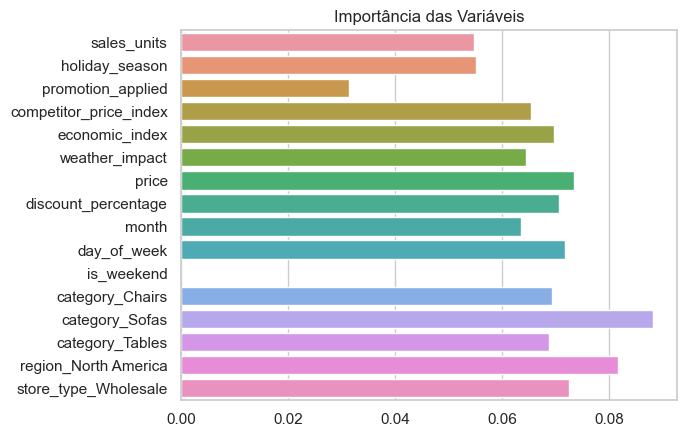

In [55]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importância das Variáveis")
plt.show()